# 1. SETTINGS

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns 

import lightgbm as lgb

import os
import time
import multiprocessing

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import tsfresh
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

import gc
gc.enable()

# 2. DATA PREPARATION

## FUNCTIONS FOR FEATURE EXTRACTION

In [2]:
### FUNCTION 1
def add_stats(agg_data, data, var):
    
    # grouped data for all features
    data_grouped = data.groupby(['object_id', 'passband'])[var]

    # compute quantiles
    for quant in [0.1, 0.25, 0.75, 0.9]:
        tmp = data_grouped.quantile(quant).reset_index()
        tmp.columns = ['object_id', 'passband', str(var) + '_q' + str(quant)[2]]
        agg_data = agg_data.merge(tmp, how = 'left', on = ['object_id', 'passband'])
        
    # kurtosis
    tmp = data_grouped.apply(lambda x: x.kurtosis()).reset_index()
    tmp.columns = ['object_id', 'passband', str(var) + '_kurtosis']
    agg_data = agg_data.merge(tmp, how = 'left', on = ['object_id', 'passband'])

    # skewness
    tmp = data_grouped.apply(lambda x: x.skew()).reset_index()
    tmp.columns = ['object_id', 'passband', str(var) + '_skew']
    agg_data = agg_data.merge(tmp, how = 'left', on = ['object_id', 'passband'])
    
    # autocorrelation
    tmp = data_grouped.apply(lambda x: x.autocorr(1)).reset_index()
    tmp.columns = ['object_id', 'passband', str(var) + '_autocorr']
    agg_data = agg_data.merge(tmp, how = 'left', on = ['object_id', 'passband'])
    
    # sample entropy
    tmp = data_grouped.apply(lambda x: tsfresh.feature_extraction.feature_calculators.sample_entropy(x)).reset_index()
    tmp.columns = ['object_id', 'passband', str(var) + '_sample_entropy']
    agg_data = agg_data.merge(tmp, how = 'left', on = ['object_id', 'passband'])
    
    # abs energy
    tmp = data_grouped.apply(lambda x: tsfresh.feature_extraction.feature_calculators.abs_energy(x)).reset_index()
    tmp.columns = ['object_id', 'passband', str(var) + '_abs_energy']
    agg_data = agg_data.merge(tmp, how = 'left', on = ['object_id', 'passband'])
    
    # number of peaks
    tmp = data_grouped.apply(lambda x: tsfresh.feature_extraction.feature_calculators.number_peaks(x, 1)).reset_index()
    tmp.columns = ['object_id', 'passband', str(var) + '_number_peaks']
    agg_data = agg_data.merge(tmp, how = 'left', on = ['object_id', 'passband'])
    
    # longest strike
    tmp = data_grouped.apply(lambda x: tsfresh.feature_extraction.feature_calculators.longest_strike_above_mean(x)).reset_index()
    tmp.columns = ['object_id', 'passband', str(var) + '_longest_strike_above_mean']
    agg_data = agg_data.merge(tmp, how = 'left', on = ['object_id', 'passband'])

    # clean up
    gc.collect()

    # return
    return agg_data

In [3]:
### FUNCTION 2
def add_features(df):
    
    # sort values
    df = df.sort_values(by = ['object_id', 'passband', 'mjd'])
        
    # transform flux to magnitudes
    #meta = pd.read_csv('../input/training_set_metadata.csv')
    #df = df.merge(meta[['object_id', 'distmod', 'hostgal_photoz']], how = 'left', on = 'object_id')
    #df['flux'] = -2.5*np.log(df.flux + 1e07)
    #df.loc[df.hostgal_photoz != 0, 'flux'] = -2.5*np.log(df.flux[df.hostgal_photoz != 0] + 1e07)
    #df['magnitude'] = df['flux'] - df['distmod']
    #del df['distmod'], df['hostgal_photoz']
  

    ### AGGREGATIONS
    
    # flux ratios
    df['flux_ratio_sq'] = np.power(df['flux'] / df['flux_err'], 2.0)
    df['flux_by_flux_ratio_sq'] = df['flux'] * df['flux_ratio_sq']
          
    # flux difference
    df['flux_diff'] = df.groupby(['object_id', 'passband']).flux.diff()
    df['flux_diff_pos'] = df['flux_diff']
    df['flux_diff_neg'] = df['flux_diff']
    df.loc[df.flux_diff > 0, 'flux_diff_neg'] = 0
    df.loc[df.detected <= 0, 'flux_diff_neg'] = 1
    df.loc[df.flux_diff > 0, 'flux_diff_pos'] = 1
    df.loc[df.detected <= 0, 'flux_diff_pos'] = 0
    
    # drop mjd without spikes
    df.loc[df.detected == 0, 'mjd'] = np.nan

    # detected flux
    df['detected_flux'] = df['flux']
    df.loc[df.detected == 0, 'detected_flux'] = np.nan

    # set aggregations
    aggs = {
        'mjd':                   ['min', 'max'],
        'flux':                  ['min', 'max', 'mean', 'median', 'std', 'var'],
        'detected_flux':         ['min', 'max', 'mean', 'median', 'std', 'var', 'skew'],
        'flux_diff':             ['min', 'max', 'mean', 'median', 'std', 'var', 'skew'],
        'flux_diff_pos':         ['mean', 'sum'],
        'flux_diff_neg':         ['mean', 'sum'],
        'flux_err':              ['min', 'max', 'mean', 'median', 'std', 'skew'],
        'detected':              ['mean', 'sum'],
        'flux_ratio_sq':         ['mean'],
        'flux_by_flux_ratio_sq': ['mean']
    }

    # aggregations
    agg_df = df.groupby(['object_id', 'passband']).agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df = agg_df.reset_index()
 

    ### EXTRA FEATURES
  
    # time range
    agg_df['mjd_diff'] = agg_df['mjd_max'] - agg_df['mjd_min']
    del agg_df['mjd_max'], agg_df['mjd_min']
    
    # flux features
    agg_df['flux_w_mean'] = agg_df['flux_by_flux_ratio_sq_mean'] / agg_df['flux_ratio_sq_mean']
    agg_df['flux_dif1']   = agg_df['flux_max'] - agg_df['flux_min']
    agg_df['flux_dif2']   = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_mean']
    agg_df['flux_dif3']   = (agg_df['flux_max'] - agg_df['flux_min']) / agg_df['flux_w_mean']

    
    ### TIME SERIES STATS
    
    # add stats
    agg_df = add_stats(agg_df, df, var = 'flux')

    # reshape to wide
    agg_df = agg_df.pivot(index = 'object_id', columns = 'passband')
    agg_df.columns = ["_p".join(map(str, col)) for col in agg_df.columns.values]
    
    # add object-specific vars
    dat = df[df.detected == 1]
    aggs = {
            'mjd':  ['min', 'max'],
            'flux': ['min', 'max', 'mean', 'median', 'std', 'var', 'skew'],
            'detected':  ['sum'],
            }
    dat = dat.groupby(['object_id']).agg(aggs)
    new_columns = [k + '_obj_' + agg for k in aggs.keys() for agg in aggs[k]]
    dat.columns = new_columns
    dat = dat.reset_index()
    dat['mjd_obj_diff'] = dat['mjd_obj_max'] - dat['mjd_obj_min']
    del dat['mjd_obj_max'], dat['mjd_obj_min']
    agg_df = agg_df.merge(dat, how = 'left', on = 'object_id')
        
    # clean up
    gc.collect()
    
    # return
    return agg_df

In [4]:
### FUNCTION 3
def add_passband_ratios(data):
    
    # ratio loop 
    for pas in [1,2,3,4,5]:
        data['p'+str(pas)+'_p0_mean_ratio'] = data['flux_mean_p'+str(pas)] / data['flux_mean_p0']
        data['p'+str(pas)+'_p0_min_ratio'] = data['flux_min_p'+str(pas)] / data['flux_min_p0']
        data['p'+str(pas)+'_p0_max_ratio'] = data['flux_max_p'+str(pas)] / data['flux_max_p0']
        data['p'+str(pas)+'_p0_detected_ratio'] = data['detected_sum_p'+str(pas)] / data['detected_sum_p0']
        data['p'+str(pas)+'_p0_d_mean_ratio'] = data['flux_diff_mean_p'+str(pas)] / data['flux_diff_mean_p0']
        data['p'+str(pas)+'_p0_d_min_ratio'] = data['flux_diff_min_p'+str(pas)] / data['flux_diff_min_p0']
        data['p'+str(pas)+'_p0_d_max_ratio'] = data['flux_diff_max_p'+str(pas)] / data['flux_diff_max_p0']
        data['p'+str(pas)+'_p0_e_mean_ratio'] = data['flux_err_mean_p'+str(pas)] / data['flux_err_mean_p0']
        data['p'+str(pas)+'_p0_e_min_ratio'] = data['flux_err_min_p'+str(pas)] / data['flux_err_min_p0']
        data['p'+str(pas)+'_p0_e_max_ratio'] = data['flux_err_max_p'+str(pas)] / data['flux_err_max_p0']

    # ratio loop 
    for pas in [2,3,4,5]:
        data['p'+str(pas)+'_p1_mean_ratio'] = data['flux_mean_p'+str(pas)] / data['flux_mean_p1']
        data['p'+str(pas)+'_p1_min_ratio'] = data['flux_min_p'+str(pas)] / data['flux_min_p1']
        data['p'+str(pas)+'_p1_max_ratio'] = data['flux_max_p'+str(pas)] / data['flux_max_p1']
        data['p'+str(pas)+'_p1_detected_ratio'] = data['detected_sum_p'+str(pas)] / data['detected_sum_p1']
        data['p'+str(pas)+'_p1_d_mean_ratio'] = data['flux_diff_mean_p'+str(pas)] / data['flux_diff_mean_p1']
        data['p'+str(pas)+'_p1_d_min_ratio'] = data['flux_diff_min_p'+str(pas)] / data['flux_diff_min_p1']
        data['p'+str(pas)+'_p1_d_max_ratio'] = data['flux_diff_max_p'+str(pas)] / data['flux_diff_max_p1']
        data['p'+str(pas)+'_p1_e_mean_ratio'] = data['flux_err_mean_p'+str(pas)] / data['flux_err_mean_p1']
        data['p'+str(pas)+'_p1_e_min_ratio'] = data['flux_err_min_p'+str(pas)] / data['flux_err_min_p1']
        data['p'+str(pas)+'_p1_e_max_ratio'] = data['flux_err_max_p'+str(pas)] / data['flux_err_max_p1']

    # ratio loop 
    for pas in [3,4,5]:
        data['p'+str(pas)+'_p2_mean_ratio'] = data['flux_mean_p'+str(pas)] / data['flux_mean_p2']
        data['p'+str(pas)+'_p2_min_ratio'] = data['flux_min_p'+str(pas)] / data['flux_min_p2']
        data['p'+str(pas)+'_p2_max_ratio'] = data['flux_max_p'+str(pas)] / data['flux_max_p2']
        data['p'+str(pas)+'_p2_detected_ratio'] = data['detected_sum_p'+str(pas)] / data['detected_sum_p2']
        data['p'+str(pas)+'_p2_d_mean_ratio'] = data['flux_diff_mean_p'+str(pas)] / data['flux_diff_mean_p2']
        data['p'+str(pas)+'_p2_d_min_ratio'] = data['flux_diff_min_p'+str(pas)] / data['flux_diff_min_p2']
        data['p'+str(pas)+'_p2_d_max_ratio'] = data['flux_diff_max_p'+str(pas)] / data['flux_diff_max_p2']
        data['p'+str(pas)+'_p2_e_mean_ratio'] = data['flux_err_mean_p'+str(pas)] / data['flux_err_mean_p2']
        data['p'+str(pas)+'_p2_e_min_ratio'] = data['flux_err_min_p'+str(pas)] / data['flux_err_min_p2']
        data['p'+str(pas)+'_p2_e_max_ratio'] = data['flux_err_max_p'+str(pas)] / data['flux_err_max_p2']

    # ratio loop 
    for pas in [4,5]:
        data['p'+str(pas)+'_p3_mean_ratio'] = data['flux_mean_p'+str(pas)] / data['flux_mean_p3']
        data['p'+str(pas)+'_p3_min_ratio'] = data['flux_min_p'+str(pas)] / data['flux_min_p3']
        data['p'+str(pas)+'_p3_max_ratio'] = data['flux_max_p'+str(pas)] / data['flux_max_p3']
        data['p'+str(pas)+'_p3_detected_ratio'] = data['detected_sum_p'+str(pas)] / data['detected_sum_p3']
        data['p'+str(pas)+'_p3_d_mean_ratio'] = data['flux_diff_mean_p'+str(pas)] / data['flux_diff_mean_p3']
        data['p'+str(pas)+'_p3_d_min_ratio'] = data['flux_diff_min_p'+str(pas)] / data['flux_diff_min_p3']
        data['p'+str(pas)+'_p3_d_max_ratio'] = data['flux_diff_max_p'+str(pas)] / data['flux_diff_max_p3']
        data['p'+str(pas)+'_p3_e_mean_ratio'] = data['flux_err_mean_p'+str(pas)] / data['flux_err_mean_p3']
        data['p'+str(pas)+'_p3_e_min_ratio'] = data['flux_err_min_p'+str(pas)] / data['flux_err_min_p3']
        data['p'+str(pas)+'_p3_e_max_ratio'] = data['flux_err_max_p'+str(pas)] / data['flux_err_max_p3']

    # ratio loop 
    for pas in [5]:
        data['p'+str(pas)+'_p4_mean_ratio'] = data['flux_mean_p'+str(pas)] / data['flux_mean_p4']
        data['p'+str(pas)+'_p4_min_ratio'] = data['flux_min_p'+str(pas)] / data['flux_min_p4']
        data['p'+str(pas)+'_p4_max_ratio'] = data['flux_max_p'+str(pas)] / data['flux_max_p4']   
        data['p'+str(pas)+'_p4_detected_ratio'] = data['detected_sum_p'+str(pas)] / data['detected_sum_p4'] 
        data['p'+str(pas)+'_p4_d_mean_ratio'] = data['flux_diff_mean_p'+str(pas)] / data['flux_diff_mean_p4']
        data['p'+str(pas)+'_p4_d_min_ratio'] = data['flux_diff_min_p'+str(pas)] / data['flux_diff_min_p4']
        data['p'+str(pas)+'_p4_d_max_ratio'] = data['flux_diff_max_p'+str(pas)] / data['flux_diff_max_p4']
        data['p'+str(pas)+'_p4_e_mean_ratio'] = data['flux_err_mean_p'+str(pas)] / data['flux_err_mean_p4']
        data['p'+str(pas)+'_p4_e_min_ratio'] = data['flux_err_min_p'+str(pas)] / data['flux_err_min_p4']
        data['p'+str(pas)+'_p4_e_max_ratio'] = data['flux_err_max_p'+str(pas)] / data['flux_err_max_p4']

    # clean up
    gc.collect()

    # return
    return data

In [5]:
### FUNCTION 4
def remove_bands(df):
    
    ##### INDIVIDUAL VARIABLES
    
    # extract some bands
    t2 = df.loc[:, df.columns.str.endswith('_p2')].divide(3)
    t3 = df.loc[:, df.columns.str.endswith('_p3')].divide(3)
    t4 = df.loc[:, df.columns.str.endswith('_p4')].divide(3)

    # rename columns
    t2.columns = [col.replace("_p2", "_p234") for col in t2.columns]
    t3.columns = [col.replace("_p3", "_p234") for col in t3.columns]
    t4.columns = [col.replace("_p4", "_p234") for col in t4.columns]

    # average
    t234 = t2.add(t3)
    t234 = t234.add(t4)

    # remove individual bands
    df = df.loc[:, ~df.columns.str.endswith('_p2')]
    df = df.loc[:, ~df.columns.str.endswith('_p3')]
    df = df.loc[:, ~df.columns.str.endswith('_p4')]

    # merge averaged band
    df = pd.concat([df, t234], axis = 1)
    
    
    ##### PASSBAND RATIOS
    
    # extract some bands
    t2 = df.filter(like = 'p2_p0').divide(3)
    t3 = df.filter(like = 'p3_p0').divide(3)
    t4 = df.filter(like = 'p4_p0').divide(3)

    # rename columns
    t2.columns = [col.replace("p2_p0", "p234_p0") for col in t2.columns]
    t3.columns = [col.replace("p3_p0", "p234_p0") for col in t3.columns]
    t4.columns = [col.replace("p4_p0", "p234_p0") for col in t4.columns]

    # average
    t234 = t2.add(t3)
    t234 = t234.add(t4)

    # remove individual bands
    #drops = list(df.filter(like = 'p2_p0').columns) + list(df.filter(like = 'p3_p0').columns) + list(df.filter(like = 'p4_p0').columns)
    #keeps = [f for f in df.columns if f not in drops]
    #df = df[keeps]

    # merge averaged band
    df = pd.concat([df, t234], axis = 1)
        
    return df

## COMPUTING FEATURES

In [294]:
### IMPORT READY DATA
full_train = pd.read_csv('../input/full_train_v10.csv')
full_train.shape

(7848, 471)

In [295]:
### AGGREGATED FLUX

# import and merge
aggflux = pd.read_csv('../input/agg_flux_train.csv')
full_train = full_train.merge(aggflux, how = 'left', on = 'object_id')
del aggflux
full_train.shape

(7848, 485)

In [296]:
### CESIUM FEATURES

# import new feats
ces = pd.read_csv('../input/cesium_train.csv')
ces.columns = ['object_id'] + ['ces_' + l.replace('__', '')[:-1] for l in list(ces.columns) if l not in 'object_id']

# filter features
ces_feats = ['object_id'] + list(ces.filter(like = 'max_slope').columns) + \
                            list(ces.filter(like = 'qso').columns) + \
                            list(ces.filter(like = 'percent_close_to_median').columns)
ces = ces[ces_feats]

# merge data
full_train = full_train.merge(ces, how = 'left', on = 'object_id')
del ces
full_train.shape

(7848, 509)

In [297]:
### REMOVE BANDS
full_train = remove_bands(full_train)
full_train.shape

(7848, 419)

In [298]:
### PREPARATIONS

# target encoding
if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# drop some features
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['hostgal_specz']

In [299]:
### PARTITIONING

# partition the data
full_train_gal = full_train[full_train.hostgal_photoz == 0]
full_train_ext = full_train[full_train.hostgal_photoz != 0]
y_gal = y[full_train.hostgal_photoz == 0]
y_ext = y[full_train.hostgal_photoz != 0]

full_train     = full_train.replace([np.inf, -np.inf], np.nan)
full_train_gal = full_train_gal.replace([np.inf, -np.inf], np.nan)
full_train_ext = full_train_ext.replace([np.inf, -np.inf], np.nan)

# impute missings with means
train_mean = full_train.median(axis = 0)
full_train_gal.fillna(train_mean, inplace = True)
full_train_ext.fillna(train_mean, inplace = True)

# save classes
classes_gal = np.sort(y_gal.unique())
classes_ext = np.sort(y_ext.unique())

# clear memory
del full_train

# 3. CROSS-VALIDATION

## GALACTIC OBJECTS

In [300]:
# exclude features
excluded_feats_gal = list(full_train_gal.filter(like = 'flux_diff_pos').columns) + \
                     list(full_train_gal.filter(like = 'flux_diff_neg').columns) + \
                     list(full_train_gal.filter(like = 'detected_flux_skew').columns) + \
                     list(full_train_gal.filter(like = 'p234_p0').columns) + \
                     list(full_train_gal.filter(like = 'detected_ratio').columns) + \
                     list(full_train_gal.filter(like = 'time_reversal_asymmetry_statistic').columns) + \
                     list(full_train_gal.filter(like = 'ces_').columns) + \
                     list(full_train_gal.filter(like = '_size').columns) + \
                     list(full_train_gal.filter(like = '_obs_').columns) + \
                     list(full_train_gal.filter(like = 'CAR').columns) + \
                     list(full_train_gal.filter(like = 'magnitude_skew').columns) + \
                     list(full_train_gal.filter(like = 'magnitude_var').columns) + \
                     list(full_train_gal.filter(like = 'magnitude_std').columns) + \
                     list(full_train_gal.filter(like = 'magnitude_min').columns) + \
                     list(full_train_gal.filter(like = 'magnitude_max').columns) + \
                     list(full_train_gal.filter(like = 'magnitude_median').columns) + \
                     list(full_train_gal.filter(like = 'magnitude_mean').columns) + \
                     ['hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'decl', 'mwebv']
features_gal = [f for f in full_train_gal.columns if f not in excluded_feats_gal]
print(full_train_gal[features_gal].shape)

(2325, 328)


In [301]:
### LOSS FUNCTION
def multi_weighted_logloss(y_true, y_preds):
    
    classes = [6, 16, 53, 65, 92]
    class_weight = dict(((c, 1) for c in classes))
    
    # reshape
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order = 'F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a = y_p, a_min = 1e-15, a_max = 1-1e-15)
    
    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis = 0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis = 0).values.astype(float)
    
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return 'wloss', loss, False


# recompute weights
w_gal = y_gal.value_counts()
weights_gal = {i : np.sum(w_gal) / w_gal[i] for i in w_gal.index}

In [302]:
### PARAMETERS

# LGB parameters
lgb_params = {
    'boosting_type':   'gbdt',
    'objective':       'multiclass',
    'num_class':        len(classes_gal),
    'metric':          'None',
    'subsample':        0.9,
    'feature_fraction': 0.7,
    'lambda_l1':        0.03,
    'lambda_l2':        0.03,
    'min_split_gain':   0.01,
    'min_child_weight': 5,
    'silent':           True,
    'verbosity':        -1,
    'learning_rate':    0.03,
    'max_depth':        3,
    'n_estimators':     5000,
    'nthread' :         16
}

# validation
folds = StratifiedKFold(n_splits     = 10, 
                        shuffle      = True, 
                        random_state = 23)

In [304]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 12, n_jobs = 10, 
           sampling_strategy = {65: 1000, 16: 1000, 92: 478, 6: 302, 53: 60})

In [305]:
trn_x, trn_y = full_train_gal[features_gal], y_gal
trn_y.value_counts() 

65    981
16    924
92    239
6     151
53     30
Name: target, dtype: int64

In [306]:
x_train_res, y_train_res = sm.fit_sample(trn_x, trn_y)
pd.Series(y_train_res).value_counts()

65    981
16    924
92    478
6     302
53     60
dtype: int64

In [307]:
### CROSS-VALIDATION LOOP

# create objects
clfs_gal = []
importances_gal = pd.DataFrame()
oof_preds_gal = np.zeros((len(full_train_gal), len(classes_gal)))

# modeling loop
start  = time.time()
for fold_, (trn_, val_) in enumerate(folds.split(y_gal, y_gal)):
    
    # data partitioning
    trn_x, trn_y = full_train_gal[features_gal].iloc[trn_], y_gal.iloc[trn_]
    val_x, val_y = full_train_gal[features_gal].iloc[val_], y_gal.iloc[val_]
    
    # SMOTE
    trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    trn_x = pd.DataFrame(trn_x, columns = features_gal)
    trn_y = pd.Series(trn_y)
    
    # train the model
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf.fit(
        trn_x, trn_y,
        eval_set              = [(trn_x, trn_y), (val_x, val_y)],
        eval_metric           = multi_weighted_logloss,
        verbose               = 100,
        early_stopping_rounds = 100,
        sample_weight         = trn_y.map(weights_gal)
    )
    clfs_gal.append(clf)

    # predictions
    oof_preds_gal[val_, :] =  clf.predict_proba(val_x, num_iteration = clf.best_iteration_)
    
    # feedback
    print('-------------------------------------')
    print('Fold ' + str(fold_ + 1) + ': LOG-LOSS = ' + str(round(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration = clf.best_iteration_))[1], 5)))  
    print('-------------------------------------')
    print('')

    # variable importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = features_gal
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances_gal = pd.concat([importances_gal, imp_df], axis = 0, sort = False)
    
    # clean up
    gc.collect()
    
# print performance
print('')
print('MULTI-WEIGHTED LOG-LOSS : %.5f ' % multi_weighted_logloss(y_true = y_gal, y_preds = oof_preds_gal)[1])
print('Done in %5.1f minutes' % ((time.time() - start) / 60))


# 328:  0.05695  --  0.05888  --  0.05346  --  0.04751

Training until validation scores don't improve for 100 rounds.
[100]	training's wloss: 0.111258	valid_1's wloss: 0.171074
[200]	training's wloss: 0.0137898	valid_1's wloss: 0.0627594
[300]	training's wloss: 0.00304847	valid_1's wloss: 0.0554523
[400]	training's wloss: 0.00138754	valid_1's wloss: 0.0555016
Early stopping, best iteration is:
[350]	training's wloss: 0.00188591	valid_1's wloss: 0.0544183
-------------------------------------
Fold 1: LOG-LOSS = 0.05442
-------------------------------------

Training until validation scores don't improve for 100 rounds.
[100]	training's wloss: 0.116192	valid_1's wloss: 0.278222
[200]	training's wloss: 0.0158501	valid_1's wloss: 0.162952
[300]	training's wloss: 0.00334401	valid_1's wloss: 0.123749
[400]	training's wloss: 0.0014352	valid_1's wloss: 0.0984419
[500]	training's wloss: 0.0010423	valid_1's wloss: 0.0823464
[600]	training's wloss: 0.000888438	valid_1's wloss: 0.0748858
[700]	training's wloss: 0.000790318	valid_1's wloss: 0.0716083
[

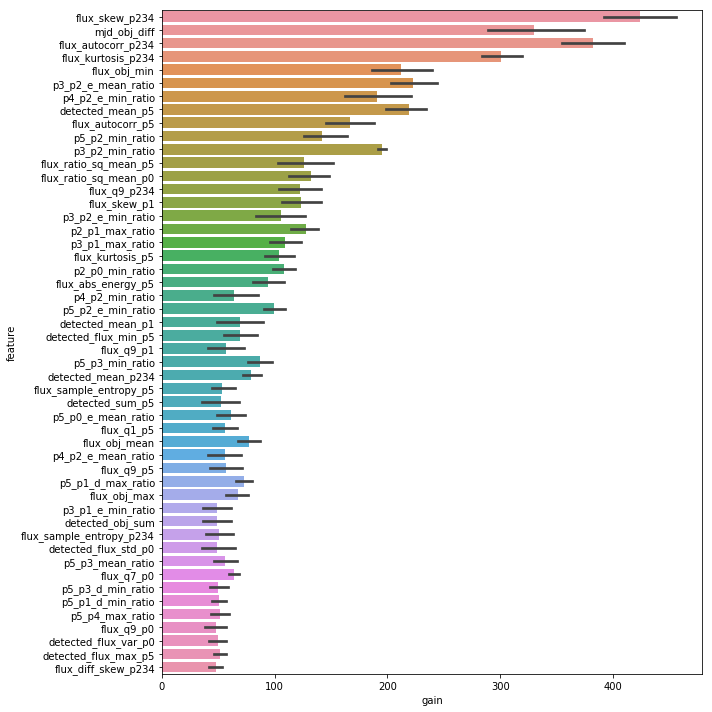

In [258]:
##### VARIABLE IMPORTANCE

# load importance 
top_feats = 50
cols = importances_gal[["gain", "feature"]].groupby("feature").mean().sort_values(by = "gain", ascending = False)[0:top_feats].index
importance = importances_gal.loc[importances_gal.feature.isin(cols)]
importance = importance.sort_values(by = "gain", ascending = False)

# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "gain", y = "feature", data = importance)
plt.tight_layout()
plt.savefig('../var_importance_gal.pdf')

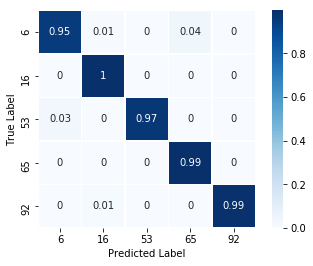

In [259]:
##### CONFUSION MATRIX

# preparations
tmp = np.argmax(oof_preds_gal, axis = 1)
y_pred = []
for i in tmp:
    y_pred.append(classes_gal[i])
y_pred = pd.Series(y_pred)

# construct confusion matrx
cm = confusion_matrix(y_gal, y_pred, labels = classes_gal)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (6,4))
sns.heatmap(cm, xticklabels = classes_gal, yticklabels = classes_gal, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

## EXTRAGALACTIC OBJECTS

In [308]:
# exclude features
excluded_feats_ext = list(full_train_ext.filter(like = 'flux_err').columns) + \
                     list(full_train_ext.filter(like = 'p2_p0').columns) + \
                     list(full_train_ext.filter(like = 'p3_p0').columns) + \
                     list(full_train_ext.filter(like = 'p4_p0').columns) + \
                     list(full_train_ext.filter(like = '_e_').columns) + \
                     list(full_train_ext.filter(like = '_d_').columns) + \
                     list(full_train_ext.filter(like = 'Period').columns) + \
                     list(full_train_ext.filter(like = 'MaxSlope').columns) + \
                     list(full_train_ext.filter(like = 'Autocor_length').columns) + \
                     list(full_train_ext.filter(like = 'magnitude_skew').columns) + \
                     list(full_train_ext.filter(like = 'magnitude_var').columns) + \
                     list(full_train_ext.filter(like = 'magnitude_std').columns) + \
                     list(full_train_ext.filter(like = 'magnitude_min').columns) + \
                     list(full_train_ext.filter(like = 'magnitude_max').columns) + \
                     list(full_train_ext.filter(like = 'magnitude_median').columns) + \
                     list(full_train_ext.filter(like = 'magnitude_mean').columns) + \
                     []
features_ext = [f for f in full_train_ext.columns if f not in excluded_feats_ext]
print(full_train_ext[features_ext].shape)

(5523, 284)


In [309]:
### LOSS FUNCTION
def multi_weighted_logloss(y_true, y_preds):
    
    classes = [15, 42, 52, 62, 64, 67, 88, 90, 95]
    class_weight = dict(((c, 1) for c in classes))
    
    # reshape
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order = 'F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a = y_p, a_min = 1e-15, a_max = 1-1e-15)
    
    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis = 0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis = 0).values.astype(float)
    
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return 'wloss', loss, False


# recompute weights
w_ext = y_ext.value_counts()
weights_ext = {i : np.sum(w_ext) / w_ext[i] for i in w_ext.index}

In [310]:
### PARAMETERS

# LGB parameters
lgb_params = {
    'boosting_type':   'gbdt',
    'objective':       'multiclass',
    'num_class':        len(classes_ext),
    'metric':          'None',
    'subsample':        0.9,
    'feature_fraction': 0.7,
    'lambda_l1':        0.03,
    'lambda_l2':        0.03,
    'min_split_gain':   0.01,
    'min_child_weight': 5,
    'silent':           True,
    'verbosity':        -1,
    'learning_rate':    0.03,
    'max_depth':        3,
    'n_estimators':     5000,
    'nthread' :         16
}

# validation
folds = StratifiedKFold(n_splits     = 10, 
                        shuffle      = True, 
                        random_state = 23)

In [313]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 12, n_jobs = 10, 
           sampling_strategy = {42:2000, 15: 500, 62: 500, 88: 500,
                                67: 416, 52: 366, 95: 350, 64: 204})

In [314]:
trn_x, trn_y = full_train_ext[features_ext], y_ext
trn_y.value_counts() 

90    2313
42    1193
15     495
62     484
88     370
67     208
52     183
95     175
64     102
Name: target, dtype: int64

In [315]:
x_train_res, y_train_res = sm.fit_sample(trn_x, trn_y)
pd.Series(y_train_res).value_counts()

90    2313
42    2000
15     500
62     500
88     500
67     416
52     366
95     350
64     204
dtype: int64

In [316]:
### CROSS-VALIDATION LOOP

# create objects
clfs_ext = []
importances_ext = pd.DataFrame()
oof_preds_ext = np.zeros((len(full_train_ext), len(classes_ext)))

# modeling loop
start  = time.time()
for fold_, (trn_, val_) in enumerate(folds.split(y_ext, y_ext)):
    
    # data partitioning
    trn_x, trn_y = full_train_ext[features_ext].iloc[trn_], y_ext.iloc[trn_]
    val_x, val_y = full_train_ext[features_ext].iloc[val_], y_ext.iloc[val_]
        
    # SMOTE
    trn_x, trn_y = sm.fit_sample(trn_x, trn_y)
    trn_x = pd.DataFrame(trn_x, columns = features_ext)
    trn_y = pd.Series(trn_y)
    
    # train the model
    clf = lgb.LGBMClassifier(**lgb_params) 
    clf.fit(
        trn_x, trn_y,
        eval_set              = [(trn_x, trn_y), (val_x, val_y)],
        eval_metric           = multi_weighted_logloss,
        verbose               = 100,
        early_stopping_rounds = 100,
        sample_weight         = trn_y.map(weights_ext)        
    )
    clfs_ext.append(clf)

    # predictions
    oof_preds_ext[val_, :] = clf.predict_proba(val_x, num_iteration = clf.best_iteration_)

    # feedback
    print('-------------------------------------')
    print('Fold ' + str(fold_ + 1) + ': LOG-LOSS = ' + str(round(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration = clf.best_iteration_))[1], 5)))  
    print('-------------------------------------')
    print('')

    # variable importance
    imp_df = pd.DataFrame()
    imp_df['feature'] = features_ext
    imp_df['gain'] = clf.feature_importances_
    imp_df['fold'] = fold_ + 1
    importances_ext = pd.concat([importances_ext, imp_df], axis = 0, sort = False)
    
    # clean up
    gc.collect()
    
# print performance
print('')
print('MULTI-WEIGHTED LOG-LOSS : %.5f ' % multi_weighted_logloss(y_true = y_ext, y_preds = oof_preds_ext)[1])
print('Done in %5.1f minutes' % ((time.time() - start) / 60))


# 284: 0.84783  --  0.85447  --  0.85590  -- 0.84624  --  0.83754

Training until validation scores don't improve for 100 rounds.
[100]	training's wloss: 0.873297	valid_1's wloss: 1.06845
[200]	training's wloss: 0.60867	valid_1's wloss: 0.904796
[300]	training's wloss: 0.473095	valid_1's wloss: 0.853315
[400]	training's wloss: 0.386611	valid_1's wloss: 0.828734
[500]	training's wloss: 0.326316	valid_1's wloss: 0.818996
[600]	training's wloss: 0.280434	valid_1's wloss: 0.815451
[700]	training's wloss: 0.242695	valid_1's wloss: 0.818667
Early stopping, best iteration is:
[605]	training's wloss: 0.278554	valid_1's wloss: 0.814311
-------------------------------------
Fold 1: LOG-LOSS = 0.81431
-------------------------------------

Training until validation scores don't improve for 100 rounds.
[100]	training's wloss: 0.872368	valid_1's wloss: 1.12798
[200]	training's wloss: 0.605038	valid_1's wloss: 0.973151
[300]	training's wloss: 0.4716	valid_1's wloss: 0.911451
[400]	training's wloss: 0.3877	valid_1's wloss: 0.882118
[500]	training's wloss: 0.326488	v

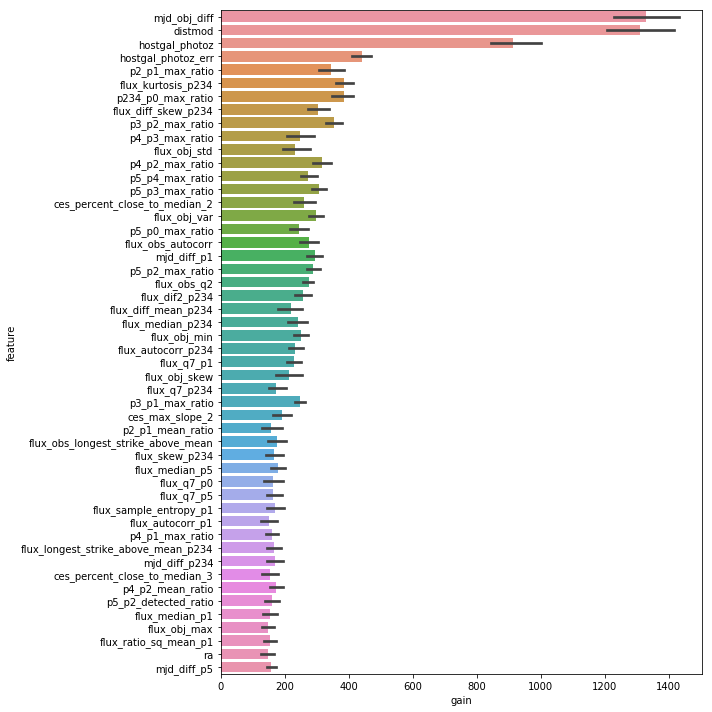

In [267]:
##### VARIABLE IMPORTANCE

# load importance 
top_feats = 50
cols = importances_ext[["gain", "feature"]].groupby("feature").mean().sort_values(by = "gain", ascending = False)[0:top_feats].index
importance = importances_ext.loc[importances_ext.feature.isin(cols)]
importance = importance.sort_values(by = "gain", ascending = False)

# plot variable importance
plt.figure(figsize = (10, 10))
sns.barplot(x = "gain", y = "feature", data = importance)
plt.tight_layout()
plt.savefig('../var_importance_ext.pdf')

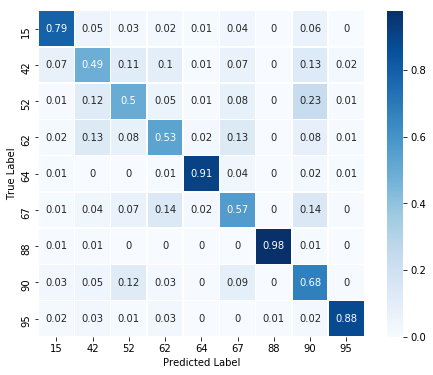

In [268]:
##### CONFUSION MATRIX

# preparations
tmp = np.argmax(oof_preds_ext, axis = 1)
y_pred = []
for i in tmp:
    y_pred.append(classes_ext[i])
y_pred = pd.Series(y_pred)

# construct confusion matrx
cm = confusion_matrix(y_ext, y_pred, labels = classes_ext)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cm, xticklabels = classes_ext, yticklabels = classes_ext, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

## OVERALL PERFORMANCE

In [269]:
### LOSS FUNCTION
def multi_weighted_logloss(y_true, y_preds):
    
    # classes
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = dict(((c, 1) for c in classes))
    
    # reshape
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order = 'F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    
    # Transform to log
    y_p_log = np.log(y_p)
    
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis = 0)
    
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis = 0).values.astype(float)
    
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    loss = - np.sum(y_w) / np.sum(class_arr)
    
    return 'wloss', loss, False

In [270]:
# merge predictions
pd_gal = pd.DataFrame(oof_preds_gal, columns = classes_gal, index = y_gal.index)
pd_ext = pd.DataFrame(oof_preds_ext, columns = classes_ext, index = y_ext.index)

# transform predictions
oof_preds = pd.concat([pd_gal, pd_ext], axis = 1)
oof_preds.sort_index(axis = 1, inplace = True)
oof_preds.fillna(0, inplace = True)

# calibration
for cl in oof_preds.columns:
    oof_preds.loc[oof_preds[cl] < 0.1, cl] = oof_preds.loc[oof_preds[cl] < 0.1, cl]*1  # 0.8
    oof_preds.loc[oof_preds[cl] > 0.9, cl] = oof_preds.loc[oof_preds[cl] > 0.9, cl]*1  # 1.5
    
# reshape
oof_preds_df = oof_preds.divide(oof_preds.sum(axis = 1), axis = 0)
oof_preds = oof_preds_df.values

In [271]:
##### EVALUATE PERFORMANCE

# print log-loss
cv_perf = multi_weighted_logloss(y_true = y, y_preds = oof_preds)[1]
print('MULTI-WEIGHTED LOG-LOSS : %.5f ' % cv_perf)

# LGB benchmark (k = 264):     0.84449
# remove mjd features (252):   0.84344
# del model-specific feats:    0.83888
# add mjd_dif for detected:    0.82858
# add detected flux + q19:     0.82632
# impute with full median:     0.82508
# add object mjd diff:         0.78257
# add other object feats:      0.77111
# add a few detect-related:    0.76727

# switching to a new loss:     0.60602
# merge p234, put feats back:  0.59091
# add skew for some feats:     0.58866
# remove some band ratios:     0.58606
# add e/d band ratios gal:     0.58195
# add cesium feats for ext:    0.57961
# add agg_flux feats for ext:  0.57753
# remove bands after feats:    0.57622
# sort values by [o,p,m]:      0.57608

# change validation strategy:  0.56662
# add SMOTE:                   0.55539

MULTI-WEIGHTED LOG-LOSS : 0.55539 


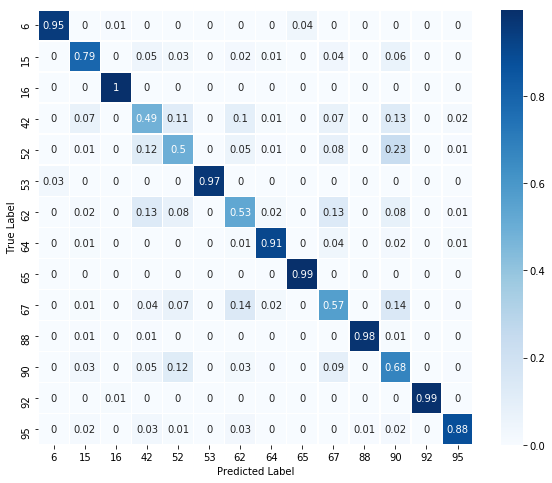

In [272]:
##### CONFUSION MATRIX

# preparations
tmp = np.argmax(oof_preds, axis = 1)
y_pred = []
for i in tmp:
    y_pred.append(classes[i])
y_pred = pd.Series(y_pred)

# construct confusion matrx
cm = confusion_matrix(y, y_pred, labels = classes)
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(cm, xticklabels = classes, yticklabels = classes, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
fig.savefig('../confusion_matrix.pdf')

# 4. PREDICTIONS

## CONSTRUCTING TEST DATA

In [273]:
### IMPORT READY DATA
start = time.time()
full_test = pd.read_csv('../input/full_test_v10.csv')
print('Done in %5.1f minutes' % ((time.time() - start) / 60))
print(full_test.shape)

Done in  11.7 minutes
(3492890, 470)


In [274]:
### AGGREGATED FLUX

# import and merge
aggflux = pd.read_csv('../input/agg_flux_test.csv')
full_test = full_test.merge(aggflux, how = 'left', on = 'object_id')
del aggflux
full_test.shape

(3492890, 484)

In [275]:
### CESIUM FEATURES

# import new feats
ces = pd.read_csv('../input/cesium_test.csv')
ces.columns = ['object_id'] + ['ces_' + l.replace('(\'', '')[:-1].replace('\', ', '_') for l in list(ces.columns) if l not in 'object_id']

# filter features
ces_feats = ['object_id'] + list(ces.filter(like = 'max_slope').columns) + \
                            list(ces.filter(like = 'qso').columns) + \
                            list(ces.filter(like = 'percent_close_to_median').columns)
ces = ces[ces_feats]

# merge data
full_test = full_test.merge(ces, how = 'left', on = 'object_id')
del ces
full_test.shape

(3492890, 508)

In [276]:
### REMOVE BANDS
full_test = remove_bands(full_test)
full_test.shape

(3492890, 418)

In [277]:
### IMPUTE SPECZ
full_test.loc[~full_test['hostgal_specz'].isnull(), 'hostgal_photoz'] = full_test.loc[~full_test['hostgal_specz'].isnull(), 'hostgal_specz']
full_test.loc[~full_test['hostgal_specz'].isnull(), 'hostgal_photoz_err'] = 0

In [278]:
### PARTITIONING

# partition the data
full_test_gal = full_test[full_test.hostgal_photoz == 0]
full_test_ext = full_test[full_test.hostgal_photoz != 0]

full_test     = full_test.replace([np.inf, -np.inf], np.nan)
full_test_gal = full_test_gal.replace([np.inf, -np.inf], np.nan)
full_test_ext = full_test_ext.replace([np.inf, -np.inf], np.nan)

# impute missings with means
test_mean = full_test.median(axis = 0)
full_test_gal.fillna(test_mean, inplace = True)
full_test_ext.fillna(test_mean, inplace = True)

# clear memory
del full_test

## PREDICTIONS

In [279]:
### PREDICT GALACTIC OBJECTS

# make predictions
start  = time.time()
preds_gal = None
for clf in clfs_gal:
    if preds_gal is None:
        preds_gal =  clf.predict_proba(full_test_gal[features_gal], num_iteration = clf.best_iteration_) / (folds.n_splits)
    else:
        preds_gal += clf.predict_proba(full_test_gal[features_gal], num_iteration = clf.best_iteration_) / (folds.n_splits)

# class 99 preds
preds_99 = np.ones(preds_gal.shape[0])
for i in range(preds_gal.shape[1]):
    preds_99 *= (1 - preds_gal[:, i])

# store predictions
preds_df_gal = pd.DataFrame(preds_gal, columns = ['class_' + str(s) for s in clfs_gal[0].classes_])
preds_df_gal['object_id'] = full_test_gal['object_id'].values
preds_df_gal['class_99'] = preds_99
preds_df_gal['class_99'] = 0.14 * preds_99 / np.mean(preds_99)

# clean up
gc.collect()
print('Predictions shape: ', preds_df_gal.shape)
print('Done in %5.1f minutes' % ((time.time() - start) / 60))

Predictions shape:  (390510, 7)
Done in   1.1 minutes


In [280]:
### PREDICT EXTRAGALACTIC OBJECTS

# make predictions
start  = time.time()
preds_ext = None
for clf in clfs_ext:
    if preds_ext is None:
        preds_ext =  clf.predict_proba(full_test_ext[features_ext], num_iteration = clf.best_iteration_) / (folds.n_splits)
    else:
        preds_ext += clf.predict_proba(full_test_ext[features_ext], num_iteration = clf.best_iteration_) / (folds.n_splits)

# class 99 preds
preds_99 = np.ones(preds_ext.shape[0])
for i in range(preds_ext.shape[1]):
    preds_99 *= (1 - preds_ext[:, i])

# store predictions
preds_df_ext = pd.DataFrame(preds_ext, columns = ['class_' + str(s) for s in clfs_ext[0].classes_])
preds_df_ext['object_id'] = full_test_ext['object_id'].values
preds_df_ext['class_99'] = preds_99
preds_df_ext['class_99'] = 0.14 * preds_99 / np.mean(preds_99)

# clean up
gc.collect()
print('Predictions shape: ', preds_df_ext.shape)
print('Done in %5.1f minutes' % ((time.time() - start) / 60))

Predictions shape:  (3102380, 11)
Done in  13.3 minutes


# 5. SEMI-SUPERVISED LEARNING

## RETRAIN LGBM ON SURE CASES: GALACTIC

## RETRAIN LGBM ON SURE CASES: EXTRAGALACTIC

# 6. CALIBRATION

In [281]:
# merge predictions
sub = pd.concat([preds_df_gal, preds_df_ext], axis = 0)
sub = sub.sort_values('object_id', ascending = True)
sub.fillna(0, inplace = True)

In [282]:
# sort and reindex
sub = sub.sort_values('object_id', ascending = True)
sub = sub.sort_index(axis = 1)
sub = sub.reset_index(drop = True)

In [283]:
# null values for galactic / extragalactic
meta_test = pd.read_csv('../input/test_set_metadata.csv')
meta_test = meta_test.sort_values('object_id')

for cl in ['class_15', 'class_42', 'class_52', 'class_62', 'class_64', 'class_67', 'class_88', 'class_90', 'class_95']:
    sub.loc[meta_test.hostgal_photoz == 0, cl] = 0

for cl in ['class_6', 'class_16', 'class_53', 'class_65', 'class_92']:
    sub.loc[meta_test.hostgal_photoz != 0, cl] = 0

In [284]:
# normalize sum to unity
sums = sub[['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']].sum(axis = 1)
for cl in ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']:
    sub[cl] = sub[cl] / sums

In [285]:
# class 99 computation
sub['class_99'] = np.ones(sub.shape[0])
for cl in ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90', 'class_92', 'class_95']: 
    sub['class_99'] *= (1 - sub[cl])
sub['class_99'] = 0.18 * sub['class_99'] / sub['class_99'].mean()

# 7. SUBMISSION

In [286]:
# file name
model = 'lgb_v10_smote'
perf  = str(round(cv_perf, 5))[2:7]
name  = model + '_' + perf

In [287]:
# export submission
sub.to_csv('../submissions/' + str(name) + '.csv', index = False)
sub.shape

(3492890, 16)

In [288]:
# export OOF preds
oof_preds_df.to_csv('../preds/' + str(name) + '.csv', index = False)
oof_preds_df.shape

(7848, 14)